In [2]:
!pip install earthengine-api

     |████████████████████████████████| 153kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 13.3MB/s eta 0:00:01
     |████████████████████████████████| 143kB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 102kB 15.4MB/s ta 0:00:01
     |████████████████████████████████| 133kB 28.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 16.0MB/s eta 0:00:01
     |████████████████████████████████| 81kB 9.7MB/s  eta 0:00:01
     |████████████████████████████████| 1.4MB 13.8MB/s eta 0:00:01
  Stored in directory: /Users/michaelkoontz/Library/Caches/pip/wheels/7b/c5/a7/ac27c1a5bebbaf335cd6805056827b4bf1c665e05ad3d40cee
  Stored in directory: /Users/michaelkoontz/Library/Caches/pip/wheels/b8/f6/f5/b7bef1a5bc0e07ca4aa54c596b0b574c5afc07a9fddccf08f8
  Stored in directory: /Users/michaelkoontz/Library/Caches/pip/wheels/9e/3d/a2/1bec8bb7db80ab3216dbc33092bb7ccd0debfb8ba42b5668d5
Successfully b

In [1]:
# Import the Earth Engine Python Package
import ee

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

elev = ee.Image("USGS/SRTMGL1_003");
gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET");
l4sr = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR");
l5sr = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR");
l7sr = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR");
l8sr = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR");

mixed_conifer = ee.Image("users/mkoontz/mixed_conifer");
sn = ee.FeatureCollection("users/mkoontz/SierraEcoregion_Jepson");
fire18_1_sn_ypmc = ee.FeatureCollection("users/mkoontz/fire18_1_sn_ypmc");

In [2]:
print(fire18_1_sn_ypmc.first().propertyNames().getInfo());

['FID', 'gis_acres', 'comments', 'ypmc_pxls', 'agency', 'inc_num', 'alarm_date', 'cause', 'area_ha', 'objective', 'c_method', 'fire_num', 'fire_name', 'cont_date', 'year_', 'state', 'unit_id', 'report_ac', 'system:index']


In [3]:
# This function appends a 'tag' string to a list (for instance band names) and returns a new list
# Example use is adding "_post" after all default bandnames for a post fire image

def paste(list1, tag):
    return list1.map(lambda x: ee.String(x).cat(ee.String('_')).cat(ee.String(tag)))


In [4]:
def mask_cloud_water_snow(resample_method):
    def mask_cloud_water_snow_internal(img):
        # Use the "closure in JavaScript technique to pass arguments to a mapped function
        # mentioned here: https://groups.google.com/d/msg/google-earth-engine-developers/jB342iaPeX4/KXJYReksDQAJ
        # demonstrated here: https://code.earthengine.google.com/80b35b7e358e94664dc6107e75a4a43a
        # Each pixel gets a 1 if it is NOT a cloud, and a 0 if it IS a cloud
        cloudMask = img.select('pixel_qa').bitwiseAnd(32).eq(0);
        # Each pixel gets a 1 if it is NOT a cloud shadow, and a 0 if it IS a cloud shadow
        cloudShadowMask = img.select('pixel_qa').bitwiseAnd(8).eq(0);
        # Each pixel gets a 1 if it is NOT water, and a 0 if it IS water
        waterMask = img.select('pixel_qa').bitwiseAnd(4).eq(0);
        # Each pixel gets a 1 if it is NOT snow, and a 0 if it IS snow
        snowMask = img.select('pixel_qa').bitwiseAnd(16).eq(0);

        # For the combined mask (1 is a pixel we want to keep, and a 0 is one we want to mask),
        # the pixel must both NOT be a cloud AND NOT be a cloud shadow AND NOT be water 
        # AND NOT be snow(a 1 for all of the above masks) in order to be a valid pixel.
        # mask = cloudMask.and(cloudShadowMask).and(waterMask).and(snowMask);
        mask = cloudMask.add(cloudShadowMask).add(waterMask).add(snowMask);
        mask = mask.eq(4);

        # Return an interpolated image with all cloud and cloud shadow pixels masked.
        # Use interpolation because CBI on-the-ground plots are unlikely to
        # lie exactly at the center of a pixel. See Cansler MSc thesis (2011)
        # and Parks et al. (2014)

        # Interpolate (resample) for on-the-ground data (cbi plot) validation
        # Don't interpolate for analyses with only remote-sensed variables

        export_img = ee.Algorithms.If(resample_method == 'none',
                                            img.updateMask(mask),
                                            img.resample(resample_method).updateMask(mask));     

        return export_img;
    return mask_cloud_water_snow_internal;

In [5]:
def rename_l8(image):
    return image.rename(['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']);


In [6]:
def merge_collections(start, end, bounds, sats):
# As of 2018-01-24, data are available between 
#  August 22, 1982 and December 14, 1993
# https://explorer.earthengine.google.com/#detail/LANDSAT%2FLT04%2FC01%2FT1_SR
# l4 is the Landsat 4 SR product filtered around the feature's 
# alarm date IF Landsat 4 is part of the desired final product
# If not, a blank image collection will be returned
   
    if '4' in sats:
        l4 = l4sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '4' not in sats: 
        l4 = ee.ImageCollection([]);
  
  # As of 2018-01-24, data are available between 
  #  January 1, 1984 to May 5, 2012
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLT05%2FC01%2FT1_SR
  # l5 is the Landsat 5 SR product filtered around the feature's 
  # alarm date IF Landsat 5 is part of the desired final product
  # If not, a blank image collection will be returned
    if '5' in sats:
        l5 = l5sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '5' not in sats: 
        l5 = ee.ImageCollection([]);
        
  # As of 2018-01-24, data are available between 
  #  January 1, 1999 and December 21, 2017
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLE07%2FC01%2FT1_SR
  # l7 is the Landsat 7 SR product filtered around the feature's 
  # alarm date IF Landsat 7 is part of the desired final product
  # If not, a blank image collection will be returned
  
  # Original band names
  # Name	Scale Factor	Description
  # B1	0.0001	Band 1 (blue) surface reflectance, 0.45-0.52 μm
  # B2	0.0001	Band 2 (green) surface reflectance, 0.52-0.60 μm
  # B3	0.0001	Band 3 (red) surface reflectance, 0.63-0.69 μm
  # B4	0.0001	Band 4 (near infrared) surface reflectance, 0.77-0.90 μm
  # B5	0.0001	Band 5 (shortwave infrared 1) surface reflectance, 1.55-1.75 μm
  # B6	0.1	Band 6 brightness temperature (Kelvin), 10.40-12.50 μm
  # B7	0.0001	Band 7 (shortwave infrared 2) surface reflectance, 2.08-2.35 μm
  # sr_atmos_opacity	0.001	Atmospheric opacity; < 0.1 = clear; 0.1 - 0.3 = average; > 0.3 = hazy
  # sr_cloud_qa		Cloud quality attributes, see SR Cloud QA table. Note: pixel_qa is likely to present more accurate results than sr_cloud_qa for cloud masking. See page 23 in the LEDAPS product guide.
  # pixel_qa		Pixel quality attributes generated from the CFMASK algorithm, see Pixel QA table
  # radsat_qa		Radiometric saturation QA, see Radiometric Saturation QA table

    if '7' in sats:
        l7 = l7sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '7' not in sats: 
        l7 = ee.ImageCollection([]);
  
  # As of 2018-01-24, data are available between 
  #  April 11, 2013 and January 3, 2018
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLC08%2FC01%2FT1_SR
  # l8 is the Landsat 8 SR product filtered around the feature's 
  # alarm date IF Landsat 8 is part of the desired final product
  # If not, a blank image collection will be returned
  
  # Original band names
  # Name	Scale Factor	Description
  # B1	0.0001	Band 1 (Ultra Blue) surface reflectance, 0.435-0.451 μm
  # B2	0.0001	Band 2 (Blue) surface reflectance, 0.452-0.512 μm
  # B3	0.0001	Band 3 (Green) surface reflectance, 0.533-0.590 μm
  # B4	0.0001	Band 4 (Red) surface reflectance, 0.636-0.673 μm
  # B5	0.0001	Band 5 (Near Infrared) surface reflectance, 0.851-0.879 μm
  # B6	0.0001	Band 6 (Shortwave Infrared 1) surface reflectance, 1.566-1.651 μm
  # B7	0.0001	Band 7 (Shortwave Infrared 2) surface reflectance, 2.107-2.294 μm
  # B10	0.1	Band 10 brightness temperature (Kelvin), 10.60-11.19 μm
  # B11	0.1	Band 11 brightness temperature (Kelvin), 11.50-12.51 μm
  # sr_aerosol		Aerosol attributes, see Aerosol QA table
  # pixel_qa		Pixel quality attributes, see Pixel QA table
  # radsat_qa		Radiometric saturation QA, see Radsat QA table

    if '8' in sats:
        l8 = l8sr.filterDate(start, end).filterBounds(bounds).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B10', 'B7', 'pixel_qa'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']);
    if '8' not in sats: 
        l8 = ee.ImageCollection([]);

    raw = l4.merge(l5).merge(l7).merge(l8);
    
    return(raw);  

In [7]:
def get_preFireRaw(feature, timeWindow, resample_method, sats):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

  # Prefire image collection derivecd by gathering all images "timeWindow"
  # (a global variable) days before the fire. 
  # These variables define the time period to grab those images. 
    preend = fireDate.advance(-1, 'day');
    prestart = preend.advance(timeWindow * -1, 'day');
  
    preFireCollection = merge_collections(prestart, preend, firePerim, sats);
    
  # We apply the cloud mask over each of those images
    preFire = preFireCollection.map(mask_cloud_water_snow(resample_method));
    
  # Return the preFire image collection
    return preFire;

In [8]:
#  get_postFireRaw() returns a post fire raw image collection. This time we look 1 year after the 
#  prefire image collection.
def get_postFireRaw(feature, timeWindow, resample_method, sats):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();
  
    # Need to get pre fire reference date in order to advance to 1 year later
    preend = fireDate.advance(-1, 'day');
    prestart = preend.advance(timeWindow * -1, 'day');
  
    # Post fire image comes from median of images exactly 1 year after pre-fire images
    poststart = prestart.advance(1, 'year');
    postend = preend.advance(1, 'year');
  
    postFireCollection = merge_collections(poststart, postend, firePerim, sats);

    # We apply the cloud mask over each of those images
    postFire = postFireCollection.map(mask_cloud_water_snow(resample_method));

    return ee.ImageCollection(postFire);

In [9]:
#  This function returns the median values for pre fire bands 1 through 7
def get_preFireRaw_median(feature, timeWindow, resample_method, sats):
  
    preFraw_median = get_preFireRaw(feature, timeWindow, resample_method, sats).median();
  
    preFraw_median = ee.Algorithms.If( preFraw_median.bandNames(),
                                    ee.Image(preFraw_median).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']).rename(paste(ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']), 'pre')), 
                                    None);

    return ee.Image(preFraw_median);

In [10]:
#  This function returns the median values for post fire bands 1 through 7
def get_postFireRaw_median(feature, timeWindow, resample_method, sats):
  
    postFraw_median = get_postFireRaw(feature, timeWindow, resample_method, sats).median();
  
    postFraw_median = ee.Algorithms.If(postFraw_median.bandNames(),
                                    ee.Image(postFraw_median)
                                      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
                                      .rename(paste(ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']), 'post')), 
                                    None);

    return ee.Image(postFraw_median);

In [11]:
# map_resample applies the user-specified resampling method to each
# image in a collection. It must be called via 'map'
# The function returns a function, which returns an image
# I just use this for resampling the GridMet collection because I already include
# resampling in the cloud mask function which is called on the raw Landsat
# images.
def map_resample(resample_method):
    def map_resample_internal(img):
        return img.resample(resample_method);
    return map_resample_internal;

In [12]:
# get_preFireGridmet() returns a collection of raw daily GRIDMET images for gridmet_timeWindow number
# of days before the fire. This collection can then be used to calculate ERC just before the fire
# and temperature/precipitation accumulation for a bit longer before the fire
def get_preFireGridmet(feature, gridmet_timeWindow, resample_method):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

    #   Prefire image collection derivecd by gathering all images 
    #   "gridmet_timeWindow" days before the fire. 
    #   These variables define the time period to grab those images. 
    prestart = fireDate.advance(gridmet_timeWindow * -1, 'day');
    preend = fireDate.advance(-1, 'day');

    #   Here is where we subset the Gridmet imagery. We filter the whole collection
    #   to just the images that were taken between "gridmet_timeWindow" days before the 
    #   fire started and 1 day before the fire started.
    preFireGridmetCol = gridmet.filterDate(prestart, preend).filterBounds(firePerim);

    preFireGridmetCol = ee.Algorithms.If(resample_method == 'none',
                                        preFireGridmetCol,
                                        preFireGridmetCol.map(map_resample(resample_method)));
  
    #   Return the preFire image collection
    return ee.ImageCollection(preFireGridmetCol);

In [13]:
# get_earlyFireGridmet() returns a collection of raw daily GRIDMET images for gridmet_timeWindow number
# of days after the fire's alarm date. This collection can then be used to calculate 
# fire weather metrics that make the most sense measured during the fire, like
# wind speed or the "Hot-dry-windy" index
def get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method):
  
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

    #   Prefire image collection derivecd by gathering all images 
    #   from the fire alarm date until "gridmet_timeWindow" days after
    #   the fire alarm date.
    #   These variables define the time period to grab those images. 
    prestart = fireDate;
    preend = fireDate.advance(gridmet_timeWindow, 'day');

    #   Here is where we subset the Gridmet imagery. We filter the whole collection
    #   to just the images that were taken between the fire's alarm date and 
    #   "gridmet_timeWindow" days after the alarm date
    earlyFireGridmetCol = gridmet.filterDate(prestart, preend).filterBounds(firePerim);
      
    earlyFireGridmetCol = ee.Algorithms.If(resample_method == 'none',
                                        earlyFireGridmetCol,
                                        earlyFireGridmetCol.map(map_resample(resample_method)));
  
    # Return the earlyFire image collection
    return ee.ImageCollection(earlyFireGridmetCol);

In [14]:
# create_kernel() returns an equally-weighted square ee.kernel with the specified number of pixel radius

# Create a kernel of a given pixel radius (number of concentric rings around focal pixel)
# Importantly, we also give 0 weight to the focal pixel.
# A radius of 1 pixel yields a 3x3 pixel kernel with a weight of 0 at the center pixel and
# a weight of 1/8 at every other pixel
# A radius of 2 pixels yields a 5x5 pixel kernel with a weight of 0 at the center pixel and
# a weight of 1/24 at every other pixel
def create_kernel(pixel_radius):
    pixel_diameter = pixel_radius.multiply(2).add(1);
    weight_val = ee.Number(1).divide((pixel_diameter.pow(2).subtract(1)));
    weights = ee.List.repeat(ee.List.repeat(weight_val, pixel_diameter), pixel_diameter);
  
    mid_row = ee.List.repeat(weight_val, pixel_radius).cat([0]).cat(ee.List.repeat(weight_val, pixel_radius));

    weights = weights.set(pixel_radius, mid_row);

    kernel = ee.Kernel.fixed(**{
        'height': pixel_diameter,
        'width': pixel_diameter,
        'weights': weights
      });
  
    return kernel;

In [15]:
# get_NDVI() returns the normalized difference vegetation index (NDVI) for each pixel of an image
def get_NDVI(img):
    ndvi = img.normalizedDifference(['B4', 'B3']).rename('ndvi').multiply(1000);
  
    return ee.Image(ndvi);


# get_preFndvi() maps over the collection of pre-fire images, calculates NDVI on each, and takes the median for each pixel
def get_preFndvi(feature, timeWindow, resample_method, sats):
  
    preFndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI).median();
  
    preFndvi = ee.Algorithms.If( preFndvi.bandNames(),
                                    ee.Image(preFndvi), 
                                    None);

    return ee.Image(preFndvi);


# get_postFndvi() maps over the collection of post-fire images, calculates NDVI on each, and takes the median for each pixel
def get_postFndvi(feature, timeWindow, resample_method, sats):

    postFndvi = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI).median();
  
    postFndvi = ee.Algorithms.If( postFndvi.bandNames(),
                                    ee.Image(postFndvi), 
                                    None);

    return ee.Image(postFndvi);



In [16]:
# get_NDMI() returns the normalized difference moisture index (NDMI) for each pixel of an image
def get_NDMI(img):
    ndmi = img.normalizedDifference(['B4', 'B5']).rename('ndmi');

    return ee.Image(ndmi);

# get_preFndmi() maps over the collection of pre-fire images, calculates NDMI on each, and takes the median for each pixel
def get_preFndmi(feature, timeWindow, resample_method, sats):
  
    preFndmi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDMI).median();
  
    preFndmi = ee.Algorithms.If( preFndmi.bandNames(),
                                    ee.Image(preFndmi), 
                                    None);

    return ee.Image(preFndmi);

# get_postFndmi() maps over the collection of post-fire images, calculates NDMI on each, and takes the median for each pixel
def get_postFndmi(feature, timeWindow, resample_method, sats):
  
    postFndmi = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NDMI).median();
  
    postFndmi = ee.Algorithms.If( postFndmi.bandNames(),
                                    ee.Image(postFndmi), 
                                    None);

    return ee.Image(postFndmi);


In [17]:
# get_NBR() returns the normalized burn ratio (NBR) for each pixel of an image
def get_NBR(img):
    nbr = img.normalizedDifference(['B4', 'B7']).rename('nbr').multiply(1000);
  
    return ee.Image(nbr);


# get_preFnbr() maps over the collection of pre-fire images, calculates NBR on each, and takes the median for each pixel
def get_preFnbr(feature, timeWindow, resample_method, sats):
  
    preFnbr = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NBR).median();
      
    preFnbr = ee.Algorithms.If( preFnbr.bandNames(),
                                    ee.Image(preFnbr), 
                                    None);

    return ee.Image(preFnbr);

# get_postFnbr() maps over the collection of post-fire images, calculates NBR on each, and takes the median for each pixel
def get_postFnbr(feature, timeWindow, resample_method, sats):
  
    postFnbr = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NBR).median();
  
    postFnbr = ee.Algorithms.If( postFnbr.bandNames(),
                                    ee.Image(postFnbr), 
                                    None);

    return ee.Image(postFnbr);

In [18]:
def get_dNBR(feature, timeWindow, resample_method, sats):
    
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    postFire_nbr = get_postFnbr(feature, timeWindow, resample_method, sats);

    dNBR = ee.Algorithms.If( preFire_nbr,
                                ee.Algorithms.If( postFire_nbr, 
                                                  preFire_nbr.subtract(postFire_nbr).rename('dnbr'), 
                                                  None),
                                None);

    return ee.Image(dNBR);

# get_RdNBR() returns the relative differenced normalized burn ratio for each pixel within the fire perimeter
# For calcuations, see Miller and Thode (2007)

def get_RdNBR(feature, timeWindow, resample_method, sats):
  
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    delta_nbr = get_dNBR(feature, timeWindow, resample_method, sats);
  
    RdNBR = ee.Algorithms.If( delta_nbr,
                                  delta_nbr.divide((preFire_nbr.abs().divide(1000)).sqrt()).rename('rdnbr'), 
                                  None);

    return ee.Image(RdNBR);

In [19]:
# get_dNDVI() returns the raw difference in NDVI between pre- and post-fire images
def get_dNDVI(feature, timeWindow, resample_method, sats):
  
    preFire_ndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    postFire_ndvi = get_postFndvi(feature, timeWindow, resample_method, sats);
  
    dNDVI = ee.Algorithms.If( preFire_ndvi.bandNames(),
                                ee.Algorithms.If( postFire_ndvi.bandNames(), 
                                                  preFire_ndvi.subtract(postFire_ndvi).rename('dndvi'), 
                                                  None),
                                None);

    return ee.Image(dNDVI);

# get_RdNDVI() returns the relative differenced normalized difference vegetation index for each pixel within a fire perimeter
# Same math as in Miller and Thode (2007), but using NDVI instead of NBR
def get_RdNDVI(feature, timeWindow, resample_method, sats):
  
    preFire_ndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    delta_ndvi = get_dNDVI(feature, timeWindow, resample_method, sats);
  
    RdNDVI = ee.Algorithms.If( delta_ndvi,
                                  delta_ndvi.divide((preFire_ndvi.abs().divide(1000)).sqrt()).rename('rdndvi'), 
                                  None);

    return ee.Image(RdNDVI);

In [20]:
# get_RBR() returns the relative burn ratio from Parks et al. 2015. Remote Sensing of the Environment))
def get_RBR(feature, timeWindow, resample_method, sats):
  
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    delta_nbr = get_dNBR(feature, timeWindow, resample_method, sats);
  
    RBR = ee.Algorithms.If( delta_nbr,
                                delta_nbr.divide(preFire_nbr.divide(1000).add(1.001)).rename('rbr'), 
                                None);

    return ee.Image(RBR);


In [21]:
# get_hetNDVI() returns the heterogeneity of NDVI within a given pixel radius for each pixel in an image
def get_hetNDVI(feature, pixel_radius, timeWindow, resample_method, sats):
    
    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    preFireCol_ndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI);

    het = preFireCol_ndvi.map(lambda img: img.reduceNeighborhood(ee.Reducer.stdDev(), kernel));
        
    het = ee.Algorithms.If( het.median().bandNames(),
                              het.median().rename(ee.String('het_ndvi_').cat(ee.String(pixel_radius))),
                              None);
    return ee.Image(het);


In [22]:
# get_focal_mean_NDVI() returns the neighborhood mean of the NDVI for a given pixel radius
# Could be valuable to account for this if using the neighborhood standard deviation at the same pixel radius
def get_neighborhood_mean_NDVI(feature, pixel_radius, timeWindow, resample_method, sats):

    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    preFireCol_ndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI);

    nbhd_mean = preFireCol_ndvi.map(lambda img: img.reduceNeighborhood(ee.Reducer.mean(), kernel));
  
    nbhd_mean = ee.Algorithms.If( nbhd_mean.median().bandNames(),
                                  nbhd_mean.median().rename(ee.String('nbhd_ndvi_').cat(ee.String(pixel_radius))),
                                  None);

    return ee.Image(nbhd_mean);

In [23]:
# Topographic variables

def get_slope(feature):
    
    terrain = ee.Algorithms.Terrain(elev);
    slope = terrain.select('slope');
    
    return(slope);

def get_aspect(feature):

    terrain = ee.Algorithms.Terrain(elev);
    aspect = terrain.select('aspect');
    
    return(aspect);

def get_roughness(feature, pixel_radius, resample_method):
    
    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    local_elev =  ee.Algorithms.If(resample_method == 'none',
                                      elev,
                                      elev.resample(resample_method));
                                      
    roughness = ee.Image(local_elev).reduceNeighborhood(ee.Reducer.stdDev(), kernel);
  
    roughness = ee.Algorithms.If( roughness.bandNames(),
                                roughness.rename(ee.String('topo_roughness_').cat(ee.String(pixel_radius))),
                                None);

    return ee.Image(roughness);

In [24]:
# Weather/fuel condition variables

def get_preFerc(feature, gridmet_timeWindow, resample_method):

    erc = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['erc']))).median();
  
    erc = ee.Algorithms.If( erc.bandNames(),
                                    ee.Image(erc).rename('preFerc'), 
                                    None);
    return ee.Image(erc);


def get_preFfm100(feature, gridmet_timeWindow, resample_method):
    
    fm100 = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['fm100']))).median();
  
    fm100 = ee.Algorithms.If( fm100.bandNames(),
                                    ee.Image(fm100).rename('preFfm100'), 
                                    None);
    return ee.Image(fm100);


def get_preFtmmx(feature, gridmet_timeWindow, resample_method):
    
    preFtmmx = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['tmmx'])).subtract(273.15)).median();
  
    preFtmmx = ee.Algorithms.If( preFtmmx.bandNames(),
                                            ee.Image(preFtmmx).rename('preFtmmx'),
                                            None);
    return ee.Image(preFtmmx);


def get_preFvpd(feature, gridmet_timeWindow, resample_method):
    
    vpd = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['vpd']))).median();
  
    vpd = ee.Algorithms.If( vpd.bandNames(),
                                    ee.Image(vpd).rename('preFvpd'), 
                                    None);
    return ee.Image(vpd);

#  Always get the early fire data for the wind speed. No point in knowing
#  wind speed before the fire.
def get_earlyFvs(feature, gridmet_timeWindow, resample_method):

    vs = get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['vs']))).median();
  
    vs = ee.Algorithms.If( vs.bandNames(),
                                    ee.Image(vs).rename('earlyFvs'), 
                                    None);
    return ee.Image(vs);

# The "Hot Dry Windy" index from Srock et al. (2018)
def get_hdw(img):

    vs = ee.Image(img.select(['vs']));
    vpd = ee.Image(img.select(['vpd']));

    hdw = vpd.multiply(vs).rename(['hdw']);
  
    return ee.Image(hdw);

def get_earlyFhdw(feature, gridmet_timeWindow, resample_method):
    
    hdw = get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method).map(get_hdw).median();
  
    hdw = ee.Algorithms.If( hdw.bandNames(),
                                    ee.Image(hdw).rename('earlyFhdw'), 
                                    None);

    return ee.Image(hdw);

def get_earlyFvpd(feature, gridmet_timeWindow, resample_method):
    
    vpd = get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['vpd']))).median();
  
    vpd = ee.Algorithms.If( vpd.bandNames(),
                                    ee.Image(vpd).rename('earlyFvpd'), 
                                    None);

    return ee.Image(vpd);

In [25]:
# A computationally lighter-weight version of the function that gets all variables
# Used to just focus on severity measurements that have demonstrated good 
# corroboration with field measurements, and excludes texture measurements

def get_variables(feature, timeWindow, resample_method, sats):
    
    geo = feature.geometry();
    
    # Static features of the point itself
    lonLat = ee.Image.pixelLonLat();
    
    slope =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                      get_slope(geo),
                                      get_slope(geo).resample(resample_method)));

    aspect =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                      get_aspect(geo),
                                      get_aspect(geo).resample(resample_method)));

    local_elev =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                        elev,
                                        elev.resample(resample_method)));

    conifer = mixed_conifer.select('b1').int().rename('ypmc');
   
    # Not dependent on neighborhood size, but derived from the fire information
    date = ee.Image(ee.Number(feature.get('alarm_date')));
    
    ordinal_day = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).getRelative('day', 'year')));
    
    day = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('day')));
    month = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('month')));
    year = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('year')));
    
    preFraw = get_preFireRaw_median(feature, timeWindow, resample_method, sats);
    postFraw = get_postFireRaw_median(feature, timeWindow, resample_method, sats);
    
    preFnbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    postFnbr = get_postFnbr(feature, timeWindow, resample_method, sats);
    rdnbr = get_RdNBR(feature, timeWindow, resample_method, sats);
    
    preFndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    postFndvi = get_postFndvi(feature, timeWindow, resample_method, sats);
    rdndvi = get_RdNDVI(feature, timeWindow, resample_method, sats);
    
    rbr = get_RBR(feature, timeWindow, resample_method, sats);
    
    # Variables that depend on neighborhood window size AND on fire information
    # Radius of 1 pixel = 3x3 window = 90m x 90m = 8100 m^2 = 0.81 ha
    het_ndvi_1 = get_hetNDVI(feature, '1', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_1 = get_neighborhood_mean_NDVI(feature, '1', timeWindow, resample_method, sats);
    rough1 = get_roughness(feature, '1', resample_method);
    
    # Radius of 2 pixels = 5x5 window = 150m x 150m = 22500 m^2 = 2.25 ha
    het_ndvi_2 = get_hetNDVI(feature, '2', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_2 = get_neighborhood_mean_NDVI(feature, '2', timeWindow, resample_method, sats);
    rough2 = get_roughness(feature, '2', resample_method);

    # Radius of 3 pixels = 7x7 window = 210m x 210m = 44100 m^2 = 4.41 ha
    het_ndvi_3 = get_hetNDVI(feature, '3', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_3 = get_neighborhood_mean_NDVI(feature, '3', timeWindow, resample_method, sats);
    rough3 = get_roughness(feature, '3', resample_method);

    # Radius of 4 pixels = 9x9 window = 270m x 270m = 72900 m^2 = 7.29 ha
    het_ndvi_4 = get_hetNDVI(feature, '4', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_4 = get_neighborhood_mean_NDVI(feature, '4', timeWindow, resample_method, sats);
    rough4 = get_roughness(feature, '4', resample_method);

    # weather/fuel condition variables
      
    erc = get_preFerc(feature, 4, resample_method); # Take the median ERC for the 3 days prior to the fire
    fm100 = get_preFfm100(feature, 4, resample_method); # Take the median 100 hour fuel moisture for 3 days prior to the fire
    preFvpd = get_preFvpd(feature, 4, resample_method); # Take the median Vapor Pressure Deficit for 3 days prior to the fire
    vs = get_earlyFvs(feature, 2, resample_method); # median windspeed from the FIRST 2 days of fire
    hdw = get_earlyFhdw(feature, 2, resample_method); # median Hot-Dry-Windy index from the FIRST 2 days of fire
    earlyFvpd = get_earlyFvpd(feature, 2, resample_method);
    
    export_weatherFuel = ee.Algorithms.If(erc,
          erc
            .addBands(fm100)
            .addBands(preFvpd)
            .addBands(vs)
            .addBands(hdw)
            .addBands(earlyFvpd),
          None);

    #      Create export image
    #      If the rdnbr variable isn't null, then all other images should have been
    #      created, since the rdnbr algorithm checks both prefire and postfire imagery
    #      and returns a null if either aren't present
  
    export_img = ee.Algorithms.If(rdnbr, 
        rdnbr
        .addBands(preFnbr)
        .addBands(postFnbr)
        .addBands(rdndvi)
        .addBands(rbr)
        .addBands(preFndvi)
        .addBands(postFndvi)
        .addBands(het_ndvi_1)
        .addBands(nbhd_mean_ndvi_1)
        .addBands(het_ndvi_2)
        .addBands(nbhd_mean_ndvi_2)
        .addBands(het_ndvi_3)
        .addBands(nbhd_mean_ndvi_3)
        .addBands(het_ndvi_4)
        .addBands(nbhd_mean_ndvi_4)
        .addBands(date)
        .addBands(ordinal_day)
        .addBands(year)
        .addBands(month)
        .addBands(day)
        .addBands(lonLat)
        .addBands(conifer)
        .addBands(slope)
        .addBands(aspect)
        .addBands(rough1)
        .addBands(rough2)
        .addBands(rough3)
        .addBands(rough4)
        .addBands(local_elev)
        .addBands(preFraw)
        .addBands(postFraw),
      None);

    export_img = ee.Algorithms.If(export_img,
                    ee.Algorithms.If(export_weatherFuel,
                          ee.Image(export_img)
                            .addBands(export_weatherFuel)
                            .copyProperties(feature),
                          None),
                        None);

    return ee.Image(export_img);

In [26]:
print(fire18_1_sn_ypmc.first().propertyNames().getInfo());

['FID', 'gis_acres', 'comments', 'ypmc_pxls', 'agency', 'inc_num', 'alarm_date', 'cause', 'area_ha', 'objective', 'c_method', 'fire_num', 'fire_name', 'cont_date', 'year_', 'state', 'unit_id', 'report_ac', 'system:index']


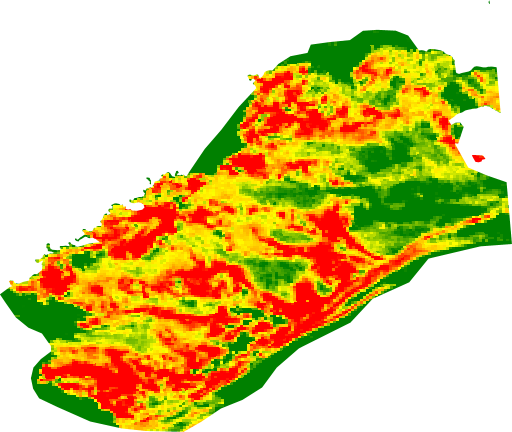

In [27]:
from IPython.display import Image, display, HTML

ftr = fire18_1_sn_ypmc.first();

timeWindow = 16*3;
gridmet_timeWindow = 4;
resample_method = 'none';
sats = ['4', '5', '7', '8'];

RBR_viz = {'bands': 'rbr', 'min': 45.09661, 'max': 282.3348, 'palette': '008000, ffff00, ffA500, ff0000'};

# Test get_variable() function
img = get_variables(ftr, timeWindow, resample_method, sats).clip(ftr);
thumburl = img.getThumbUrl(RBR_viz);
img_thumb = Image(url = thumburl, embed = True, format = 'png');
display(img_thumb);

In [28]:
def assess_whole_fire(timeWindow, resample_method, sats):
  
    def assess_whole_fire_internal(feature):
        geo = feature.geometry();
        var_img = get_variables(feature, timeWindow, resample_method, sats);
  
        export_img = ee.Algorithms.If(var_img, 
                                      ee.Image(var_img).clip(geo).copyProperties(feature), 
                                      None);

        return ee.Image(export_img);
    
    return assess_whole_fire_internal;
    

In [47]:
# Add an alarm_year attribute to each feature
fire18_1_sn_ypmc = fire18_1_sn_ypmc.map(lambda ftr: ftr.set({'alarm_year': ee.Date(ftr.get('alarm_date')).get('year')}));

total_fires = fire18_1_sn_ypmc.filter(ee.Filter.gt('alarm_year', 1983)).size().getInfo();
print(total_fires);


1142


In [54]:
fire_ids = ["00000000000000000163", "000000000000000001c3", "00000000000000000225", "0000000000000000013f", "000000000000000001b2", "0000000000000000023c", "0000000000000000023f", "000000000000000001b3", "000000000000000003a6", "00000000000000000165", "000000000000000002ab", "000000000000000003a5", "0000000000000000023b", "000000000000000001b4", "0000000000000000023e", "000000000000000002ad", "0000000000000000023d", "00000000000000000213", "0000000000000000019e", "000000000000000002ac", "000000000000000001c4", "00000000000000000164", "000000000000000003a8", "00000000000000000183", "000000000000000003a7", "0000000000000000040e", "00000000000000000187", "00000000000000000184", "00000000000000000185", "0000000000000000017e", "00000000000000000198", "000000000000000003a9", "000000000000000002a4", "00000000000000000186", "00000000000000000417", "00000000000000000418", "00000000000000000420", "000000000000000003aa", "00000000000000000435", "00000000000000000436", "00000000000000000437", "000000000000000001b5", "00000000000000000294", "00000000000000000433", "00000000000000000434", "00000000000000000430", "00000000000000000431", "00000000000000000432", "00000000000000000197", "0000000000000000041f", "000000000000000002a5", "00000000000000000182", "0000000000000000017d", "00000000000000000140", "000000000000000002a6", "000000000000000003ab", "00000000000000000142", "0000000000000000040f", "0000000000000000028e", "00000000000000000111", "00000000000000000411", "000000000000000003ae", "00000000000000000118", "000000000000000003a0", "00000000000000000425", "00000000000000000283", "00000000000000000116", "000000000000000000eb", "000000000000000000ec", "00000000000000000438", "00000000000000000102", "00000000000000000416", "000000000000000003af", "00000000000000000141", "00000000000000000115", "00000000000000000117", "00000000000000000246", "00000000000000000226", "000000000000000002c0", "000000000000000003b1", "00000000000000000145", "00000000000000000100", "00000000000000000143", "00000000000000000419", "000000000000000003b5", "0000000000000000041e", "000000000000000003a1", "00000000000000000424", "000000000000000003b2", "00000000000000000422", "00000000000000000161", "0000000000000000029d", "0000000000000000024a", "00000000000000000177", "00000000000000000109", "000000000000000002bf", "00000000000000000144", "00000000000000000101", "000000000000000001c6", "000000000000000000e0", "000000000000000000ff", "0000000000000000029f", "00000000000000000248", "000000000000000003a3", "00000000000000000175", "00000000000000000176", "00000000000000000178", "00000000000000000247", "00000000000000000249", "0000000000000000024b", "0000000000000000024c", "0000000000000000024d", "00000000000000000168", "000000000000000002be", "0000000000000000046f", "00000000000000000119", "0000000000000000029a", "000000000000000002b1", "000000000000000002bd", "000000000000000000e1", "000000000000000002a0", "000000000000000002a8", "0000000000000000046e", "0000000000000000029e", "0000000000000000041d", "000000000000000003a2", "00000000000000000439", "000000000000000003b3", "000000000000000003b4", "00000000000000000162", "0000000000000000025c", "000000000000000000fc", "000000000000000000fd", "000000000000000000ee", "00000000000000000258", "00000000000000000253", "000000000000000003b9", "00000000000000000410", "0000000000000000041b", "000000000000000003bb", "0000000000000000044a", "00000000000000000426", "00000000000000000259", "00000000000000000295", "00000000000000000265", "000000000000000001bf", "000000000000000003be", "00000000000000000136", "000000000000000001bd", "00000000000000000255", "000000000000000002a9", "000000000000000003b6", "000000000000000003bd", "0000000000000000025d", "000000000000000003ba", "00000000000000000264", "00000000000000000421", "00000000000000000296", "0000000000000000025e", "0000000000000000025f", "00000000000000000260", "00000000000000000261", "00000000000000000254", "00000000000000000282", "0000000000000000025b", "0000000000000000043d", "00000000000000000263", "0000000000000000041a", "000000000000000003b7", "00000000000000000423", "000000000000000003b8", "0000000000000000043c", "000000000000000000f7", "000000000000000000e2", "00000000000000000104", "00000000000000000251", "00000000000000000256", "00000000000000000262", "0000000000000000043b", "000000000000000003ea", "00000000000000000427", "0000000000000000043a", "000000000000000002a7", "00000000000000000257", "0000000000000000041c", "000000000000000001be", "0000000000000000025a", "000000000000000003bc", "00000000000000000252", "00000000000000000293", "00000000000000000250", "000000000000000000fb", "000000000000000000fe", "000000000000000001cc", "0000000000000000018d", "00000000000000000147", "00000000000000000148", "000000000000000000ef", "00000000000000000191", "00000000000000000193", "00000000000000000194", "00000000000000000195", "00000000000000000146", "00000000000000000190", "00000000000000000196", "000000000000000001cd", "00000000000000000192", "000000000000000001ce", "0000000000000000018e", "0000000000000000018f", "00000000000000000266", "0000000000000000026a", "000000000000000003db", "0000000000000000014b", "000000000000000000e3", "0000000000000000026d", "00000000000000000103", "00000000000000000267", "00000000000000000268", "00000000000000000269", "000000000000000001d1", "00000000000000000149", "00000000000000000414", "0000000000000000010e", "000000000000000003f9", "0000000000000000014a", "0000000000000000043e", "000000000000000002b3", "000000000000000003da", "000000000000000003dc", "00000000000000000412", "00000000000000000413", "00000000000000000477", "000000000000000002b2", "00000000000000000286", "0000000000000000010f", "00000000000000000110", "0000000000000000026c", "0000000000000000026b", "0000000000000000026e", "00000000000000000272", "0000000000000000014c", "0000000000000000026f", "000000000000000001ee", "000000000000000001ef", "00000000000000000472", "000000000000000001f0", "00000000000000000270", "000000000000000003dd", "000000000000000003de", "00000000000000000473", "0000000000000000042d", "0000000000000000042e", "00000000000000000441", "0000000000000000043f", "00000000000000000440", "00000000000000000399", "000000000000000003df", "00000000000000000271", "00000000000000000273", "000000000000000003bf", "00000000000000000428", "000000000000000000e4", "000000000000000001d2", "000000000000000003c1", "000000000000000003c2", "00000000000000000429", "0000000000000000042a", "000000000000000001ff", "00000000000000000442", "0000000000000000029b", "0000000000000000015f", "00000000000000000137", "000000000000000001d3", "00000000000000000470", "00000000000000000138", "000000000000000001c5", "000000000000000003c0", "00000000000000000200", "000000000000000002ae", "000000000000000003c4", "0000000000000000014d", "00000000000000000210", "000000000000000003c6", "000000000000000003eb", "000000000000000003c3", "000000000000000003c5", "000000000000000001f9", "00000000000000000236", "00000000000000000156", "000000000000000001d6", "00000000000000000159", "00000000000000000167", "00000000000000000107", "000000000000000001fb", "000000000000000003ed", "00000000000000000155", "000000000000000003f0", "0000000000000000015e", "0000000000000000015a", "0000000000000000013c", "000000000000000001d5", "000000000000000001d4", "00000000000000000291", "0000000000000000013b", "0000000000000000028f", "000000000000000000f6", "00000000000000000290", "000000000000000001fa", "000000000000000001fc", "000000000000000003ef", "000000000000000003ee", "000000000000000003ec", "0000000000000000014e", "000000000000000001d7", "00000000000000000444", "000000000000000001c0", "0000000000000000019f", "000000000000000003c8", "000000000000000000e5", "00000000000000000132", "00000000000000000443", "00000000000000000231", "00000000000000000219", "000000000000000003c7", "000000000000000000d7", "0000000000000000010d", "00000000000000000240", "0000000000000000014f", "0000000000000000013e", "000000000000000003c9", "000000000000000003cd", "000000000000000003cf", "00000000000000000447", "00000000000000000448", "00000000000000000244", "0000000000000000012d", "000000000000000003ca", "00000000000000000446", "000000000000000003cb", "0000000000000000012e", "000000000000000001f3", "000000000000000003ce", "00000000000000000241", "00000000000000000445", "000000000000000001bc", "0000000000000000010b", "0000000000000000012c", "0000000000000000012f", "00000000000000000245", "00000000000000000292", "000000000000000003cc", "00000000000000000287", "00000000000000000288", "000000000000000001b6", "00000000000000000289", "0000000000000000028a", "0000000000000000028b", "0000000000000000028c", "000000000000000003f8", "000000000000000000d8", "00000000000000000243", "00000000000000000242", "000000000000000001bb", "0000000000000000010c", "0000000000000000015c", "00000000000000000139", "000000000000000001db", "000000000000000001dc", "00000000000000000130", "000000000000000000d2", "00000000000000000449", "00000000000000000238", "00000000000000000239", "000000000000000000d1", "000000000000000000e6", "000000000000000001dd", "0000000000000000019a", "0000000000000000019b", "00000000000000000237", "000000000000000002c1", "000000000000000001da", "000000000000000000d3", "000000000000000003d0", "000000000000000000d4", "000000000000000001d9", "0000000000000000019c", "000000000000000003d1", "000000000000000001f4", "000000000000000002c2", "0000000000000000024f", "0000000000000000024e", "0000000000000000023a", "000000000000000003d2", "000000000000000000f5", "000000000000000000f4", "00000000000000000204", "0000000000000000019d", "0000000000000000042b", "000000000000000001f5", "00000000000000000297", "000000000000000002bc", "00000000000000000232", "0000000000000000042c", "0000000000000000022c", "000000000000000001b7", "000000000000000000cc", "000000000000000000cd", "000000000000000000ce", "000000000000000001fd", "000000000000000001fe", "00000000000000000227", "00000000000000000228", "0000000000000000022a", "0000000000000000022b", "0000000000000000022d", "0000000000000000022e", "000000000000000002bb", "00000000000000000229", "000000000000000002aa", "0000000000000000018a", "0000000000000000039d", "00000000000000000233", "0000000000000000017a", "0000000000000000018b", "0000000000000000039e", "00000000000000000189", "000000000000000001f6", "000000000000000003d3", "00000000000000000471", "000000000000000001f7", "000000000000000001e5", "000000000000000002af", "000000000000000001e4", "000000000000000001b8", "000000000000000001e1", "000000000000000001e6", "0000000000000000039f", "000000000000000001e2", "000000000000000001e3", "0000000000000000018c", "00000000000000000234", "000000000000000000f9", "0000000000000000013d", "00000000000000000235", "000000000000000001cf", "000000000000000000cf", "000000000000000001c9", "000000000000000003ac", "000000000000000002a3", "00000000000000000160", "000000000000000002a1", "0000000000000000017b", "00000000000000000128", "00000000000000000201", "00000000000000000188", "00000000000000000299", "00000000000000000108", "000000000000000001cb", "000000000000000003d4", "00000000000000000298", "0000000000000000015d", "00000000000000000202", "000000000000000000f3", "00000000000000000129", "000000000000000002a2", "0000000000000000012a", "000000000000000002b0", "0000000000000000017f", "00000000000000000166", "000000000000000001eb", "000000000000000003d5", "00000000000000000150", "000000000000000001d8", "0000000000000000017c", "000000000000000003e9", "000000000000000000ed", "00000000000000000151", "00000000000000000203", "0000000000000000020e", "000000000000000003d9", "00000000000000000134", "000000000000000000e9", "000000000000000003d8", "0000000000000000022f", "000000000000000001ec", "000000000000000003b0", "000000000000000003e2", "000000000000000003e5", "000000000000000003e1", "000000000000000003e3", "00000000000000000230", "000000000000000003e6", "000000000000000001ca", "000000000000000000ea", "000000000000000003d7", "000000000000000001d0", "000000000000000001e8", "000000000000000003d6", "000000000000000002ba", "0000000000000000011a", "0000000000000000011b", "000000000000000003e0", "000000000000000003e4", "000000000000000001ed", "00000000000000000207", "000000000000000000e7", "000000000000000001e7", "000000000000000000e8", "000000000000000000f8", "0000000000000000011c", "0000000000000000011d", "0000000000000000011e", "0000000000000000012b", "00000000000000000152", "000000000000000001e9", "00000000000000000199", "000000000000000001c1", "000000000000000001c2", "00000000000000000208", "00000000000000000209", "0000000000000000020a", "0000000000000000020b", "0000000000000000020c", "0000000000000000020d", "00000000000000000206", "00000000000000000154", "0000000000000000011f", "00000000000000000120", "00000000000000000205", "00000000000000000153", "000000000000000003e8", "00000000000000000131", "0000000000000000021a", "000000000000000001f1", "000000000000000003f4", "000000000000000003f5", "000000000000000002b7", "000000000000000000f1", "000000000000000001b1", "000000000000000002b8", "00000000000000000135", "000000000000000001a1", "000000000000000002b9", "0000000000000000039b", "000000000000000002b6", "000000000000000003fb", "0000000000000000039c", "000000000000000003fa", "000000000000000000d0", "000000000000000001a5", "000000000000000003f1", "000000000000000001a3", "0000000000000000010a", "0000000000000000039a", "000000000000000000f0", "00000000000000000121", "000000000000000003f2", "000000000000000003f3", "000000000000000002b4", "000000000000000002b5", "000000000000000001a2", "00000000000000000105", "00000000000000000106", "000000000000000003e7", "0000000000000000013a", "000000000000000003a4", "000000000000000001a4", "00000000000000000157", "000000000000000001a0", "00000000000000000158", "0000000000000000020f", "00000000000000000133", "0000000000000000015b", "0000000000000000021c", "00000000000000000123", "00000000000000000124", "0000000000000000021b", "00000000000000000179", "000000000000000003f7", "00000000000000000214", "00000000000000000127", "00000000000000000114", "00000000000000000397", "00000000000000000398", "000000000000000003f6", "00000000000000000220", "000000000000000001ea", "0000000000000000021d", "00000000000000000125", "0000000000000000021f", "00000000000000000211", "00000000000000000212", "0000000000000000021e", "00000000000000000285", "00000000000000000122", "000000000000000003ad", "000000000000000001f2", "000000000000000001c7", "00000000000000000126", "00000000000000000007", "000000000000000001f8", "0000000000000000028d", "00000000000000000113", "00000000000000000112", "00000000000000000415", "000000000000000000f2", "000000000000000000fa", "000000000000000000df", "000000000000000000ca", "00000000000000000392", "00000000000000000393", "00000000000000000394", "000000000000000000cb", "0000000000000000038e", "000000000000000000d9", "000000000000000000da", "00000000000000000180", "00000000000000000390", "000000000000000000c8", "000000000000000000db", "000000000000000000de", "00000000000000000181", "00000000000000000391", "00000000000000000395", "00000000000000000396", "000000000000000001c8", "000000000000000000c9", "0000000000000000038f", "0000000000000000044b", "0000000000000000044c", "000000000000000000c7", "000000000000000000dc", "000000000000000001b0", "00000000000000000275", "0000000000000000027a", "0000000000000000027b", "0000000000000000027c", "0000000000000000027d", "00000000000000000277", "000000000000000001e0", "00000000000000000274", "000000000000000001df", "000000000000000001a9", "00000000000000000218", "0000000000000000027e", "0000000000000000027f", "00000000000000000279", "000000000000000001de", "000000000000000001aa", "000000000000000001a7", "000000000000000001ae", "000000000000000001ab", "000000000000000001af", "00000000000000000276", "000000000000000001ac", "00000000000000000280", "00000000000000000169", "000000000000000001ad", "00000000000000000281", "00000000000000000474", "00000000000000000223", "00000000000000000222", "00000000000000000221", "000000000000000001a8", "000000000000000001a6", "0000000000000000029c", "000000000000000000d6", "00000000000000000476", "00000000000000000278", "000000000000000000af", "00000000000000000224", "000000000000000000d5", "00000000000000000217", "00000000000000000216", "000000000000000000dd", "00000000000000000475", "00000000000000000215", "000000000000000000ac", "000000000000000000c1", "000000000000000000b3", "000000000000000000b9", "000000000000000000b5", "000000000000000000a9", "000000000000000000bc", "000000000000000000bd", "000000000000000000bf", "000000000000000000b1", "000000000000000000aa", "000000000000000000ae", "000000000000000000b4", "00000000000000000388", "000000000000000000c3", "000000000000000000b6", "000000000000000000c5", "000000000000000000b2", "000000000000000000c4", "000000000000000000b7", "000000000000000000b0", "000000000000000000bb", "000000000000000000b8", "000000000000000000c0", "000000000000000000ba", "00000000000000000389", "000000000000000000ad", "0000000000000000038a", "000000000000000000be", "000000000000000000c2", "000000000000000000c6", "0000000000000000038b", "0000000000000000038c", "000000000000000000ab", "00000000000000000387", "0000000000000000038d", "000000000000000002c8", "000000000000000002f7", "000000000000000002d7", "000000000000000002cb", "000000000000000002c9", "000000000000000002ee", "000000000000000002ca", "000000000000000002d4", "000000000000000002d5", "000000000000000002d6", "000000000000000002c5", "000000000000000002e4", "000000000000000002ef", "000000000000000002f0", "000000000000000002f1", "000000000000000002f2", "000000000000000002f3", "000000000000000002cd", "000000000000000002ce", "0000000000000000016a", "000000000000000002da", "000000000000000002de", "000000000000000002df", "000000000000000002e0", "000000000000000002e1", "000000000000000002e2", "000000000000000002e5", "000000000000000002e6", "000000000000000002ea", "000000000000000002ec", "000000000000000002fb", "000000000000000002cf", "000000000000000002d0", "000000000000000002d1", "000000000000000002d2", "000000000000000002d3", "000000000000000002ff", "000000000000000002e7", "000000000000000002e8", "000000000000000002e9", "000000000000000002eb", "000000000000000002ed", "000000000000000002f6", "000000000000000002c4", "00000000000000000478", "000000000000000002fc", "000000000000000002f9", "000000000000000003fc", "00000000000000000008", "000000000000000002fa", "000000000000000003fe", "00000000000000000479", "000000000000000002dc", "000000000000000002e3", "000000000000000002d8", "000000000000000002cc", "000000000000000002d9", "000000000000000002db", "000000000000000002c3", "000000000000000002fd", "000000000000000002c6", "000000000000000002c7", "000000000000000003fd", "000000000000000002f5", "000000000000000002dd", "000000000000000002f8", "000000000000000002fe", "000000000000000002f4", "00000000000000000009", "00000000000000000311", "00000000000000000305", "000000000000000003ff", "00000000000000000400", "00000000000000000401", "0000000000000000030a", "0000000000000000030b", "00000000000000000302", "0000000000000000030c", "00000000000000000300", "00000000000000000303", "00000000000000000306", "00000000000000000301", "00000000000000000406", "0000000000000000030d", "0000000000000000030f", "00000000000000000403", "00000000000000000407", "00000000000000000307", "00000000000000000304", "00000000000000000308", "00000000000000000404", "00000000000000000402", "00000000000000000310", "0000000000000000030e", "00000000000000000309", "00000000000000000405", "0000000000000000016c", "0000000000000000040b", "00000000000000000409", "00000000000000000315", "0000000000000000016d", "0000000000000000040d", "00000000000000000317", "00000000000000000316", "0000000000000000016b", "00000000000000000170", "0000000000000000040a", "0000000000000000040c", "00000000000000000318", "00000000000000000313", "00000000000000000314", "0000000000000000016e", "00000000000000000312", "00000000000000000408", "0000000000000000016f", "0000000000000000033a", "00000000000000000450", "00000000000000000330", "0000000000000000032c", "0000000000000000032e", "0000000000000000044e", "0000000000000000031c", "0000000000000000032d", "0000000000000000032b", "00000000000000000331", "0000000000000000044d", "00000000000000000329", "00000000000000000332", "0000000000000000031a", "00000000000000000328", "00000000000000000322", "00000000000000000336", "0000000000000000044f", "00000000000000000451", "0000000000000000033b", "00000000000000000334", "0000000000000000032f", "00000000000000000335", "00000000000000000323", "00000000000000000319", "0000000000000000031e", "00000000000000000320", "00000000000000000321", "00000000000000000326", "00000000000000000337", "00000000000000000338", "00000000000000000339", "0000000000000000031b", "0000000000000000031d", "0000000000000000032a", "0000000000000000031f", "00000000000000000327", "00000000000000000324", "00000000000000000325", "00000000000000000452", "00000000000000000333", "00000000000000000350", "00000000000000000344", "0000000000000000034c", "00000000000000000454", "00000000000000000349", "00000000000000000341", "00000000000000000342", "00000000000000000453", "00000000000000000358", "00000000000000000357", "00000000000000000346", "00000000000000000347", "00000000000000000345", "00000000000000000353", "0000000000000000034d", "00000000000000000355", "0000000000000000033d", "0000000000000000034a", "00000000000000000348", "00000000000000000356", "0000000000000000033f", "0000000000000000034f", "00000000000000000352", "00000000000000000343", "0000000000000000033e", "0000000000000000034e", "0000000000000000034b", "00000000000000000340", "0000000000000000033c", "00000000000000000351", "00000000000000000354", "0000000000000000036c", "0000000000000000036b", "00000000000000000371", "00000000000000000455", "00000000000000000368", "0000000000000000036d", "00000000000000000367", "0000000000000000035c", "00000000000000000456", "00000000000000000366", "00000000000000000459", "00000000000000000359", "0000000000000000035a", "0000000000000000036e", "00000000000000000370", "0000000000000000035f", "0000000000000000036f", "0000000000000000035d", "00000000000000000364", "00000000000000000365", "0000000000000000036a", "00000000000000000457", "00000000000000000361", "00000000000000000362", "00000000000000000363", "00000000000000000458", "00000000000000000369", "0000000000000000035e", "00000000000000000360", "0000000000000000035b", "0000000000000000037f", "0000000000000000037d", "0000000000000000037a", "00000000000000000465", "00000000000000000468", "0000000000000000037c", "00000000000000000469", "0000000000000000037b", "0000000000000000046a", "00000000000000000002", "00000000000000000379", "00000000000000000000", "00000000000000000003", "00000000000000000004", "00000000000000000005", "0000000000000000045d", "00000000000000000466", "0000000000000000046b", "00000000000000000386", "0000000000000000046d", "0000000000000000037e", "00000000000000000383", "0000000000000000045a", "0000000000000000045e", "0000000000000000045f", "00000000000000000467", "00000000000000000006", "00000000000000000374", "00000000000000000382", "00000000000000000372", "00000000000000000375", "00000000000000000380", "00000000000000000381", "00000000000000000385", "00000000000000000376", "00000000000000000373", "00000000000000000378", "0000000000000000045b", "00000000000000000460", "00000000000000000377", "00000000000000000001", "00000000000000000384", "00000000000000000461", "00000000000000000462", "0000000000000000045c", "00000000000000000463", "00000000000000000464", "00000000000000000020", "00000000000000000021", "00000000000000000025", "0000000000000000000b", "00000000000000000022", "0000000000000000001d", "0000000000000000001e", "00000000000000000026", "0000000000000000001a", "00000000000000000010", "00000000000000000024", "00000000000000000019", "00000000000000000029", "00000000000000000015", "00000000000000000016", "0000000000000000046c", "00000000000000000011", "00000000000000000023", "0000000000000000001c", "00000000000000000012", "00000000000000000049", "0000000000000000000c", "0000000000000000000f", "00000000000000000017", "00000000000000000013", "0000000000000000001f", "0000000000000000000d", "0000000000000000001b", "00000000000000000027", "00000000000000000028", "0000000000000000000a", "0000000000000000000e", "00000000000000000018", "00000000000000000014", "0000000000000000002c", "0000000000000000003d", "00000000000000000174", "00000000000000000043", "00000000000000000044", "0000000000000000002e", "00000000000000000173", "00000000000000000048", "00000000000000000035", "00000000000000000032", "0000000000000000002a", "00000000000000000042", "0000000000000000002f", "00000000000000000030", "00000000000000000045", "00000000000000000036", "0000000000000000003c", "00000000000000000172", "0000000000000000003b", "0000000000000000003e", "0000000000000000002d", "00000000000000000040", "0000000000000000003a", "00000000000000000041", "0000000000000000002b", "00000000000000000046", "00000000000000000047", "00000000000000000031", "00000000000000000034", "00000000000000000038", "0000000000000000003f", "00000000000000000033", "00000000000000000037", "00000000000000000039", "00000000000000000171", "00000000000000000064", "00000000000000000074", "0000000000000000007d", "00000000000000000084", "0000000000000000005c", "00000000000000000067", "0000000000000000006a", "00000000000000000056", "0000000000000000005f", "0000000000000000007c", "00000000000000000072", "0000000000000000006f", "00000000000000000073", "0000000000000000004c", "00000000000000000052", "0000000000000000007f", "0000000000000000004d", "00000000000000000081", "00000000000000000088", "00000000000000000077", "0000000000000000004b", "0000000000000000006b", "0000000000000000007b", "00000000000000000085", "0000000000000000007e", "00000000000000000086", "00000000000000000075", "00000000000000000065", "00000000000000000061", "00000000000000000060", "00000000000000000087", "00000000000000000083", "00000000000000000054", "00000000000000000058", "00000000000000000069", "00000000000000000059", "00000000000000000071", "00000000000000000076", "0000000000000000005a", "00000000000000000062", "0000000000000000005d", "0000000000000000004e", "00000000000000000063", "00000000000000000051", "00000000000000000055", "0000000000000000006c", "0000000000000000006d", "00000000000000000053", "00000000000000000057", "00000000000000000070", "00000000000000000066", "00000000000000000080", "00000000000000000082", "0000000000000000005b", "0000000000000000005e", "0000000000000000007a", "00000000000000000068", "0000000000000000004f", "00000000000000000050", "00000000000000000078", "0000000000000000004a", "00000000000000000079", "0000000000000000006e", "0000000000000000009b", "00000000000000000096", "0000000000000000009f", "00000000000000000092", "00000000000000000093", "0000000000000000009e", "000000000000000000a1", "000000000000000000a6", "0000000000000000009c", "00000000000000000091", "00000000000000000094", "00000000000000000095", "000000000000000000a8", "0000000000000000008e", "00000000000000000090", "0000000000000000009d", "0000000000000000009a", "0000000000000000008a", "000000000000000000a5", "000000000000000000a7", "000000000000000000a0", "00000000000000000099", "00000000000000000089", "0000000000000000008d", "00000000000000000098", "000000000000000000a2", "000000000000000000a3", "00000000000000000097", "000000000000000000a4", "0000000000000000008f", "0000000000000000008c", "0000000000000000008b"]
alarm_dates = ["19840508", "19840508", "19840519", "19840528", "19840529", "19840529", "19840529", "19840628", "19840630", "19840707", "19840716", "19840818", "19840819", "19840821", "19840821", "19840824", "19840826", "19840908", "19840917", "19840918", "19840921", "19841028", "19850616", "19850619", "19850625", "19850630", "19850630", "19850702", "19850705", "19850706", "19850709", "19850711", "19850712", "19850713", "19850725", "19850725", "19850728", "19850728", "19850729", "19850729", "19850730", "19850802", "19850802", "19850803", "19850803", "19850806", "19850806", "19850806", "19850809", "19850809", "19850810", "19850810", "19850817", "19850826", "19850831", "19851015", "19860611", "19860627", "19860715", "19860716", "19860723", "19860723", "19860724", "19860724", "19860727", "19860812", "19860814", "19860816", "19860816", "19860820", "19860909", "19860927", "19861002", "19861017", "19861029", "19861226", "19870207", "19870422", "19870508", "19870601", "19870613", "19870622", "19870626", "19870628", "19870628", "19870707", "19870708", "19870717", "19870719", "19870723", "19870729", "19870731", "19870809", "19870818", "19870822", "19870828", "19870829", "19870829", "19870829", "19870829", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870830", "19870831", "19870831", "19870831", "19870831", "19870831", "19870901", "19870901", "19870903", "19870910", "19870921", "19870921", "19870921", "19870926", "19870929", "19871112", "19880216", "19880317", "19880317", "19880327", "19880327", "19880510", "19880523", "19880620", "19880620", "19880620", "19880620", "19880621", "19880624", "19880702", "19880704", "19880718", "19880718", "19880719", "19880721", "19880721", "19880721", "19880721", "19880722", "19880723", "19880723", "19880724", "19880724", "19880727", "19880727", "19880727", "19880801", "19880803", "19880809", "19880810", "19880810", "19880810", "19880811", "19880811", "19880812", "19880813", "19880818", "19880818", "19880819", "19880828", "19880828", "19880828", "19880829", "19880829", "19880831", "19880902", "19880902", "19880908", "19880909", "19880910", "19880910", "19880911", "19881011", "19881016", "19881206", "19881210", "19881214", "19881215", "19881215", "19881215", "19890411", "19890621", "19890703", "19890707", "19890708", "19890723", "19890728", "19890729", "19890802", "19890906", "19890909", "19890915", "19891109", "19891118", "19891120", "19891229", "19900430", "19900629", "19900713", "19900730", "19900803", "19900805", "19900805", "19900806", "19900806", "19900806", "19900807", "19900807", "19900807", "19900807", "19900807", "19900808", "19900808", "19900809", "19900809", "19900809", "19900813", "19900813", "19900830", "19900913", "19900913", "19901014", "19901027", "19901110", "19901113", "19901209", "19910105", "19910120", "19910120", "19910120", "19910120", "19910120", "19910224", "19910419", "19910729", "19910823", "19910904", "19910906", "19910906", "19910907", "19910907", "19910907", "19910912", "19910926", "19920203", "19920504", "19920602", "19920621", "19920704", "19920704", "19920715", "19920716", "19920721", "19920811", "19920812", "19920814", "19920816", "19920820", "19920822", "19920907", "19920907", "19920913", "19920929", "19921009", "19930510", "19930510", "19930622", "19930713", "19930816", "19930901", "19930902", "19930907", "19931108", "19940101", "19940102", "19940302", "19940302", "19940514", "19940526", "19940603", "19940617", "19940623", "19940627", "19940719", "19940727", "19940804", "19940804", "19940807", "19940807", "19940809", "19940811", "19940814", "19940816", "19940818", "19940824", "19940915", "19940922", "19940924", "19940925", "19941025", "19950709", "19950718", "19950730", "19950808", "19950808", "19950811", "19950829", "19950913", "19951104", "19951108", "19951109", "19951119", "19960215", "19960502", "19960621", "19960623", "19960627", "19960711", "19960712", "19960713", "19960713", "19960725", "19960726", "19960726", "19960727", "19960728", "19960729", "19960801", "19960802", "19960809", "19960810", "19960812", "19960812", "19960812", "19960812", "19960812", "19960812", "19960813", "19960813", "19960813", "19960814", "19960814", "19960814", "19960814", "19960814", "19960814", "19960818", "19960825", "19960826", "19960920", "19961002", "19961021", "19961107", "19970411", "19970417", "19970505", "19970508", "19970512", "19970517", "19970517", "19970518", "19970521", "19970706", "19970726", "19970726", "19970728", "19970806", "19970806", "19970808", "19970815", "19970904", "19970905", "19970908", "19970923", "19970927", "19971005", "19971009", "19971024", "19980719", "19981020", "19990112", "19990331", "19990709", "19990711", "19990711", "19990714", "19990806", "19990810", "19990811", "19990812", "19990822", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990823", "19990824", "19990909", "19990910", "19990918", "19991008", "19991016", "19991017", "19991115", "19991129", "19991208", "20000101", "20000104", "20000331", "20000529", "20000628", "20000703", "20000715", "20000722", "20000728", "20000729", "20000801", "20000802", "20000802", "20000803", "20000813", "20000816", "20000817", "20000902", "20000920", "20000920", "20001016", "20010107", "20010416", "20010502", "20010510", "20010527", "20010617", "20010703", "20010709", "20010724", "20010725", "20010730", "20010807", "20010812", "20010817", "20010817", "20010818", "20010818", "20010819", "20010819", "20010819", "20010820", "20010825", "20010904", "20010905", "20010906", "20010910", "20010925", "20011024", "20011027", "20011110", "20020406", "20020601", "20020615", "20020626", "20020630", "20020701", "20020703", "20020711", "20020711", "20020711", "20020713", "20020719", "20020721", "20020724", "20020726", "20020730", "20020806", "20020818", "20020819", "20020826", "20020912", "20020924", "20020926", "20021010", "20021010", "20021107", "20021112", "20021115", "20021116", "20021124", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021125", "20021126", "20021126", "20021127", "20021127", "20021127", "20021130", "20030708", "20030710", "20030710", "20030718", "20030719", "20030719", "20030719", "20030720", "20030720", "20030720", "20030723", "20030724", "20030728", "20030728", "20030729", "20030729", "20030729", "20030729", "20030730", "20030731", "20030731", "20030821", "20030825", "20030825", "20030831", "20030831", "20030831", "20030831", "20030831", "20030831", "20030903", "20030903", "20030903", "20030903", "20030904", "20030904", "20030905", "20030924", "20030927", "20031018", "20031018", "20031117", "20031123", "20040411", "20040427", "20040504", "20040507", "20040523", "20040530", "20040616", "20040616", "20040617", "20040627", "20040630", "20040707", "20040709", "20040712", "20040722", "20040728", "20040728", "20040806", "20040806", "20040808", "20040809", "20040812", "20040812", "20040828", "20040905", "20040911", "20040912", "20040912", "20040917", "20041006", "20041013", "20041015", "20041120", "20041124", "20050315", "20050721", "20050721", "20050721", "20050721", "20050722", "20050722", "20050724", "20050809", "20050824", "20050825", "20050916", "20050917", "20050922", "20050922", "20050926", "20050926", "20050926", "20050927", "20050930", "20051024", "20051027", "20051027", "20051118", "20051119", "20060516", "20060625", "20060625", "20060625", "20060625", "20060625", "20060627", "20060627", "20060627", "20060628", "20060628", "20060706", "20060709", "20060709", "20060716", "20060718", "20060719", "20060721", "20060721", "20060721", "20060722", "20060723", "20060723", "20060726", "20060807", "20060807", "20060809", "20060811", "20060816", "20060819", "20060820", "20060821", "20060824", "20060830", "20060902", "20060903", "20060904", "20060905", "20060906", "20060919", "20060919", "20060919", "20060919", "20060924", "20061010", "20070405", "20070510", "20070603", "20070623", "20070623", "20070624", "20070705", "20070705", "20070705", "20070706", "20070706", "20070706", "20070710", "20070710", "20070724", "20070807", "20070809", "20070809", "20070810", "20070818", "20070822", "20070822", "20070822", "20070826", "20070826", "20070830", "20070903", "20070905", "20070909", "20071021", "20071028", "20071029", "20071029", "20071030", "20071101", "20071108", "20080305", "20080416", "20080506", "20080514", "20080515", "20080531", "20080613", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080621", "20080622", "20080622", "20080622", "20080622", "20080628", "20080629", "20080630", "20080702", "20080708", "20080708", "20080710", "20080713", "20080715", "20080719", "20080725", "20080727", "20080729", "20080803", "20080804", "20080806", "20080806", "20080811", "20080816", "20080830", "20080901", "20080910", "20080911", "20080913", "20080928", "20081015", "20081027", "20081112", "20090420", "20090422", "20090518", "20090530", "20090608", "20090617", "20090628", "20090628", "20090629", "20090715", "20090715", "20090715", "20090718", "20090719", "20090720", "20090726", "20090728", "20090729", "20090802", "20090815", "20090816", "20090821", "20090826", "20090912", "20090912", "20090919", "20090927", "20100715", "20100717", "20100717", "20100724", "20100725", "20100725", "20100728", "20100731", "20100807", "20100808", "20100808", "20100808", "20100813", "20100820", "20100827", "20100912", "20100918", "20100930", "20101003", "20110429", "20110624", "20110708", "20110711", "20110719", "20110730", "20110819", "20110820", "20110823", "20110825", "20110830", "20110904", "20110904", "20110909", "20110910", "20110912", "20110912", "20110913", "20110913", "20110914", "20110922", "20110924", "20111115", "20111130", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111201", "20111202", "20111203", "20111204", "20111204", "20111216", "20111221", "20120113", "20120305", "20120601", "20120616", "20120619", "20120620", "20120711", "20120715", "20120725", "20120725", "20120728", "20120728", "20120728", "20120804", "20120804", "20120804", "20120805", "20120805", "20120806", "20120807", "20120810", "20120810", "20120811", "20120815", "20120818", "20120902", "20120904", "20120913", "20120926", "20121006", "20121029", "20130317", "20130429", "20130504", "20130509", "20130511", "20130514", "20130616", "20130708", "20130722", "20130722", "20130723", "20130803", "20130803", "20130805", "20130810", "20130813", "20130817", "20130818", "20130818", "20130818", "20130818", "20130818", "20130818", "20130818", "20130818", "20130823", "20130823", "20130831", "20131027", "20131218", "20140111", "20140113", "20140613", "20140614", "20140619", "20140701", "20140704", "20140711", "20140714", "20140715", "20140717", "20140720", "20140720", "20140720", "20140720", "20140720", "20140720", "20140720", "20140721", "20140726", "20140727", "20140729", "20140802", "20140805", "20140807", "20140808", "20140811", "20140818", "20140818", "20140818", "20140905", "20140906", "20140910", "20140913", "20140913", "20140914", "20140916", "20140921", "20140921", "20140921", "20141007", "20141008", "20141016", "20141016", "20141022", "20141025", "20141110", "20150124", "20150124", "20150206", "20150207", "20150222", "20150328", "20150421", "20150602", "20150618", "20150702", "20150703", "20150703", "20150703", "20150709", "20150709", "20150716", "20150719", "20150719", "20150721", "20150723", "20150725", "20150725", "20150726", "20150727", "20150729", "20150731", "20150805", "20150808", "20150814", "20150908", "20150910", "20150911", "20151005", "20151020", "20160301", "20160405", "20160612", "20160613", "20160621", "20160623", "20160626", "20160627", "20160628", "20160628", "20160701", "20160712", "20160721", "20160806", "20160806", "20160816", "20160819", "20160819", "20160829", "20160907", "20160911", "20160913", "20160913", "20160915", "20160917", "20160922", "20160923", "20160926", "20161003", "20161004", "20161014", "20161020", "20161029", "20161029", "20161105", "20170621", "20170621", "20170621", "20170621", "20170624", "20170630", "20170630", "20170703", "20170708", "20170708", "20170709", "20170710", "20170712", "20170712", "20170716", "20170716", "20170721", "20170723", "20170724", "20170726", "20170727", "20170729", "20170731", "20170802", "20170802", "20170802", "20170803", "20170806", "20170807", "20170807", "20170813", "20170815", "20170818", "20170818", "20170820", "20170824", "20170828", "20170829", "20170829", "20170829", "20170829", "20170830", "20170901", "20170903", "20170903", "20170905", "20170908", "20170911", "20170911", "20170912", "20170912", "20170912", "20170912", "20170918", "20170925", "20170926", "20170927", "20171008", "20171008", "20171008", "20171009", "20171009", "20171010", "20180426", "20180521", "20180619", "20180708", "20180712", "20180713", "20180713", "20180719", "20180724", "20180726", "20180730", "20180801", "20180801", "20180804", "20180805", "20180807", "20180903", "20180904", "20180904", "20180908", "20180914", "20180915", "20180920", "20180922", "20181004", "20181004", "20181012", "20181013", "20181013", "20181015", "20181104", "20181108"]

# First, start at 0
# If this ever breaks or if you accidentally stop it (like by closing your laptop-- ask me how I know)
# It should be straightforward to restart the process where you left off by substituting 0 in 
# the range(0, len(fire_ids)) for the last iteration that was submitted (look for this in the printed output
# below this cell or on the task list in the JavaScript playground)

#  Loop through all images, add the date to the appropriate list element, and export image
# for i in range(825, len(fire_ids)):
for i in range(0, len(fire_ids)):
    this_fire = fire18_1_sn_ypmc.filter(ee.Filter.eq('system:index', fire_ids[i]));
    fire_assessment = this_fire.map(assess_whole_fire(timeWindow, resample_method, sats), True);
    
    img = ee.Image(fire_assessment.first());
    
    if img.getInfo() is None:
        continue;
    
    date = alarm_dates[i];
    id = fire_ids[i];

    fileNamePrefix = str(date) + "_" + str(i + 1).zfill(5) + "_" + id + "_epsg3310"

    ee.batch.Export.image.toDrive(**{
            'image': img.float(),
            'description': fileNamePrefix,
            'fileNamePrefix': fileNamePrefix, 
            'folder': 'ee/frap-derived-fire-imagery', 
            'scale': 30,
            'crs': 'EPSG:3310'
        }).start();

    print(str(i + 1) + " of " + str(total_fires) + " submitted to Google for processing.")